# Preprocessing proposal 

## Rotate x and z axis such that x aligns with child's height and z aligns with depth

### Method based on maskrcnn + line fitting histogram

The idea of the method is quite simple:
1. use maskrcnn to get a rough idea of the child's location on the depthmap;
2. consider vertical strips of pixels in the depthmap (only within the child's location); 
3. for each vertical strip, compute the slope of the least-squares line interpolating the depth values;
4. find the most common slope value, which can be interpreted as the angle at which the axis is tilted;
5. rotate the xz plane to counterbalance the effect of the tilting angle.

This notebook showcases the implementation of this algorithm in the `Task3.adjust_axis.maskrnn_hist` class. This class exposes the `fit, transform, fit_transform` interface as well as a `fit_transform_pyntcloud` method for convenience.

Note: until now, I've only tested this on front scans

In [3]:
import numpy as np
import azureml.core
from azureml.core import Workspace
from azureml.core.dataset import Dataset
from pyntcloud import PyntCloud
import pandas as pd
import pythreejs
import pickle
import os
import seaborn as sns
import matplotlib.pyplot as plt
import random

from PIL import Image, ImageOps

import scipy.stats
# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

%matplotlib inline

Azure ML SDK Version:  1.16.0


In [4]:
def get_timestamp_from_pcd(pcd_path):
    filename = str(pcd_path)
    infile = open(filename, 'r')
    try:
        firstLine = infile.readline()
    except Exception as error:
        print(error)
        print(pcd_path)
        return -1
    # get the time from the header of the pcd file
    import re
    timestamp = re.findall(r'\d+\.\d+', firstLine)
    # check if a timestamp is parsed from the header of the pcd file
    try:
        return_timestamp = float(timestamp[0])
    except IndexError:
        return_timestamp = []
    return return_timestamp  # index error? IndexError

def get_timestamp_from_rgb(rgb_path):
    return float(rgb_path[0:-4].split('/')[-1].split('_')[-1])

def find_closest(A, target):
    # A must be sorted
    idx = A.searchsorted(target)
    idx = np.clip(idx, 1, len(A) - 1)
    left = A[idx - 1]
    right = A[idx]
    idx -= target - left < right - target
    return idx

# Preparation

## mount datasets

In [5]:
ws = Workspace.from_config() 

In [6]:
dataset_depth = Dataset.get_by_name(ws, name='anon_depthmap_training')

In [7]:
%%time
mount_context_depth = dataset_depth.mount()
mount_context_depth.start()  # this will mount the file streams
print(mount_context_depth.mount_point)

/tmp/tmpo2x95m_o
CPU times: user 532 ms, sys: 96.4 ms, total: 629 ms
Wall time: 13.3 s


In [8]:
dataset_rgb = Dataset.get_by_name(ws, name='anon_rgb_training')

In [9]:
%%time
mount_context_rgb = dataset_rgb.mount()
mount_context_rgb.start()  # this will mount the file streams
print(mount_context_rgb.mount_point)

/tmp/tmp0oe3vlxu
CPU times: user 315 ms, sys: 76.3 ms, total: 391 ms
Wall time: 5.93 s


In [10]:
pcd_files_base_path = './dataset/pcd'
depth_files_base_path = mount_context_depth.mount_point
rgb_base_path = mount_context_rgb.mount_point

## randomly choose a front pose scan

And get the depthmap, rgb image and point cloud data

In [11]:
while True:
    qrcode = random.sample(os.listdir(f'{pcd_files_base_path}/scans'), 1)[0]
    try:
        file = random.sample(os.listdir(depth_files_base_path + '/scans/' + qrcode + '/100'), 1)[0]
    except FileNotFoundError:
        continue
    print(qrcode)
    print(file)
    break

1585002575-eteul8qbts
pc_1585002575-eteul8qbts_1591706265423_100_007.p


In [12]:
pickle_sample = depth_files_base_path + '/scans/' + qrcode + '/100/' + file 
depthmap,labels= pickle.load(open(pickle_sample,"rb"))

In [13]:
%%time
rgb_files = os.listdir(f'{mount_context_rgb.mount_point}/scans/{qrcode}/100')
rgb_timestamps = np.array([get_timestamp_from_rgb(x) for x in rgb_files])
sorting_indices = rgb_timestamps.argsort()
rgb_timestamps = rgb_timestamps[sorting_indices]

target_timestamp = get_timestamp_from_pcd(pcd_files_base_path + '/scans/' + qrcode + '/100/' + file + 'cd')

CPU times: user 24.9 ms, sys: 9.81 ms, total: 34.7 ms
Wall time: 1min 21s


In [14]:
idx = find_closest(rgb_timestamps, target_timestamp)
rgb_file = f'{mount_context_rgb.mount_point}/scans/{qrcode}/100/{rgb_files[idx]}'

Short preprocessing of the rgb image 

In [15]:
im = Image.open(rgb_file)
im = im.rotate(-90, expand=True)
im = ImageOps.mirror(im)
im = im.resize((135, 180))

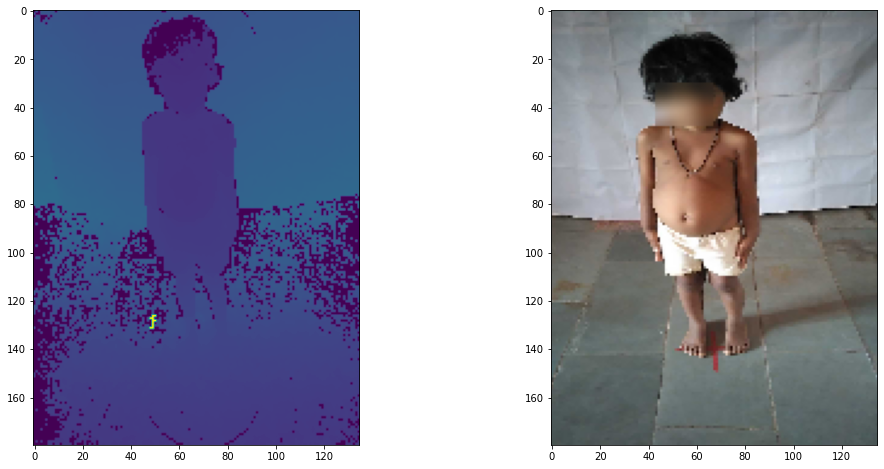

In [16]:
fig, ax = plt.subplots(1,2,figsize=(17,8))

ax[0].imshow(np.squeeze(depthmap))
ax[1].imshow(np.array(im))

# Apply axis realignment

Requires adding the child growth monitor directory to the path

In [18]:
import sys
sys.path.append('./ChildGrowthMonitor')

In [40]:
from Task3 import adjust_axis

In [49]:
adjuster = adjust_axis.maskrnn_hist('calibration-lenovo-phab.txt')

In [50]:
output = PyntCloud.from_file(f'{pcd_files_base_path}/scans/{qrcode}/100/{file}cd')

## directly transform the pyntcloud

In [51]:
%%time
adjusted_output = adjuster.fit_transform_pyntcloud(
    output,
    depthmap,
    im
)

CPU times: user 7.77 s, sys: 13.1 ms, total: 7.79 s
Wall time: 4.18 s


### Before

the child is clearly tilted

<AxesSubplot:xlabel='Count', ylabel='z'>

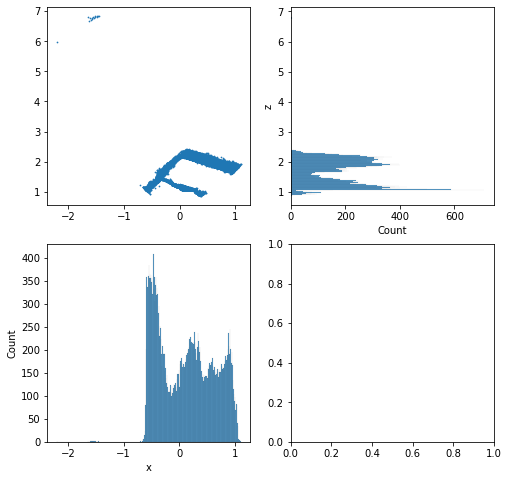

In [52]:
fig, axs = plt.subplots(2,2,figsize=(8,8))

axs[0][0].scatter(output.points.x, output.points.z, s=0.5)
sns.histplot(data=output.points, x='x', ax=axs[1][0], binwidth=0.01)
sns.histplot(data=output.points, y='z', ax=axs[0][1], binwidth=0.01)

### After adjustment

If the algorithm worked, the child's height should be parallel to the x axis below

<AxesSubplot:xlabel='Count', ylabel='z'>

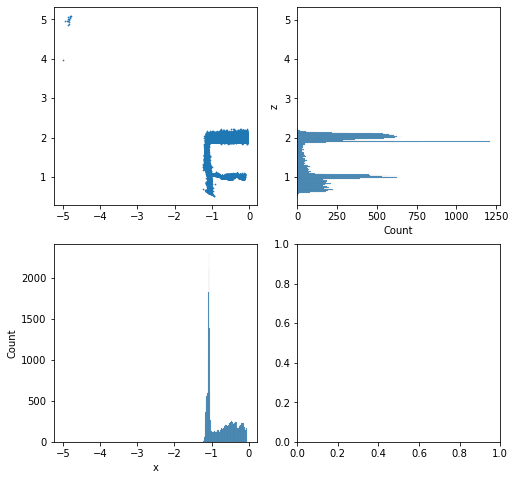

In [53]:
fig, axs = plt.subplots(2,2,figsize=(8,8))

axs[0][0].scatter(adjusted_output.points.x, adjusted_output.points.z, s=0.5)
sns.histplot(data=adjusted_output.points, x='x', ax=axs[1][0], binwidth=0.01)
sns.histplot(data=adjusted_output.points, y='z', ax=axs[0][1], binwidth=0.01)

## transform instead an array of x,y,z values

In [54]:
points_as_array = output.xyz

In [56]:
%%time
adjusted_array = adjuster.fit_transform(
    points_as_array,
    depthmap,
    im
)

CPU times: user 7.66 s, sys: 28 ms, total: 7.69 s
Wall time: 4.12 s


Same result as before

<AxesSubplot:xlabel='Count'>

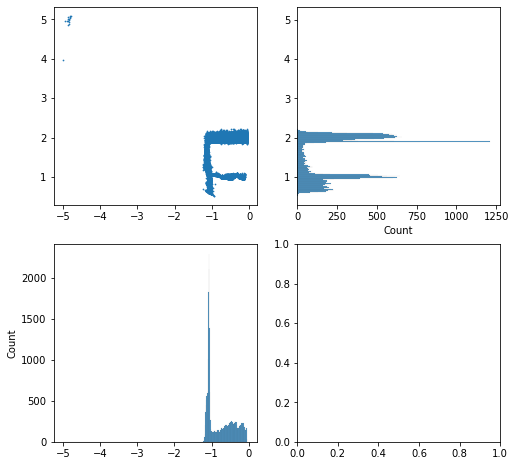

In [57]:
fig, axs = plt.subplots(2,2,figsize=(8,8))

axs[0][0].scatter(adjusted_array[:,0], adjusted_array[:,2], s=0.5)
sns.histplot(x=adjusted_array[:,0], ax=axs[1][0], binwidth=0.01)
sns.histplot(y=adjusted_array[:,2], ax=axs[0][1], binwidth=0.01)